# White Noise Validation: JUG vs PINT

Verify that JUG's EFAC, EQUAD, and ECORR implementations match PINT on real data.

**Dataset**: B1855+09 — NANOGrav 9-year (4005 TOAs, 4 backends, 4 ECORRs)

| Noise param | 430_ASP | 430_PUPPI | L-wide_ASP | L-wide_PUPPI |
|---|---|---|---|---|
| **EFAC** | 1.147 | 1.117 | 1.150 | 1.507 |
| **EQUAD** (µs) | 0.01410 | 0.02640 | 0.42504 | 0.25518 |
| **ECORR** (µs) | 0.01117 | 0.00601 | 0.79618 | 0.31843 |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pint.models as pm
import pint.toa as pt
import pint.residuals

# JUG noise modules
from jug.noise.white import WhiteNoiseEntry, parse_noise_lines, build_backend_mask, apply_white_noise
from jug.noise.ecorr import ECORRWhitener, EpochGroup, build_ecorr_whitener, _group_toas_into_epochs

plt.rcParams.update({'figure.dpi': 120, 'font.size': 10})

# Load B1855+09 in PINT
PAR = '/home/mattm/soft/PINT/tests/datafile/B1855+09_NANOGrav_9yv1.gls.par'
TIM = '/home/mattm/soft/PINT/tests/datafile/B1855+09_NANOGrav_9yv1.tim'
model = pm.get_model(PAR)
toas = pt.get_TOAs(TIM)
print(f"Loaded {toas.ntoas} TOAs for B1855+09")

2026-02-10 12:45:35.029 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2026-02-10 12:45:35.033 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = True)
2026-02-10 12:45:35.130 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2026-02-10 12:45:35.131 | DEBUG    | pint.observatory:_load_gps_clock:108 - Loading global GPS clock file
2026-02-10 12:45:35.133 | DEBUG    | pint.observatory.clock_file:__init__:812 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2026-02-10 12:45:35.134 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:463 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/home/mattm/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2026-02-10 12:45:35.142 | INFO     | pint.observatory:find_clock_file:9

Loaded 4005 TOAs for B1855+09


## 1. Extract PINT quantities

Get the raw and EFAC/EQUAD-scaled uncertainties, backend flags, prefit residuals, and ECORR epoch structure from PINT.

In [2]:
# --- PINT: raw & scaled uncertainties ---
raw_sigma_us = toas.get_errors().to('us').value          # original TOA errors (µs)
pint_scaled_sigma_us = model.scaled_toa_uncertainty(toas).to('us').value  # EFAC/EQUAD-scaled

# --- PINT: backend flags and MJDs ---
flags_f = np.array(toas.get_flag_value('f')[0])          # backend flag per TOA
mjds = toas.get_mjds().value                              # MJD array

# --- PINT: prefit residuals ---
res = pint.residuals.Residuals(toas, model)
pint_resid_us = res.time_resids.to('us').value

# --- PINT: ECORR epoch structure ---
ecorr_comp = model.components['EcorrNoise']
U_pint = ecorr_comp.get_noise_basis(toas)                # (ntoa x nepoch) quantization matrix
J_pint = ecorr_comp.get_noise_weights(toas)              # ECORR^2 per epoch (s^2)

backends = sorted(set(flags_f))
print(f"Backends: {backends}")
print(f"Raw σ range: {raw_sigma_us.min():.3f} – {raw_sigma_us.max():.3f} µs")
print(f"PINT scaled σ range: {pint_scaled_sigma_us.min():.3f} – {pint_scaled_sigma_us.max():.3f} µs")
print(f"ECORR epochs: {U_pint.shape[1]}, singletons: {toas.ntoas - int(U_pint.sum())}")

2026-02-10 12:45:40.536 | INFO     | pint.solar_system_ephemerides:_load_kernel_link:85 - Set solar system ephemeris to de421 from download
2026-02-10 12:45:40.656 | DEBUG    | pint.toa:add_vel_ecl:2496 - Adding column ssb_obs_vel_ecl
2026-02-10 12:45:40.656 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2026-02-10 12:45:40.658 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2026-02-10 12:45:40.661 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2026-02-10 12:45:40.683 | DEBUG    | pint.models.astrometry:ssb_to_psb_xyz_ECL:983 - ECL not specified; using IERS2010.
2026-02-10 12:45:40.688 | DEBUG    | pint.models.absolute_phase:get_TZR_toa:101 - Creating and dealing with the single TZR_toa for absolute phase
2026-02-10 12:45:40.689 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2026-02-10 12:45:40.689 | DEBUG    | 

Backends: [np.str_('430_ASP'), np.str_('430_PUPPI'), np.str_('L-wide_ASP'), np.str_('L-wide_PUPPI')]
Raw σ range: 0.050 – 17.811 µs
PINT scaled σ range: 0.404 – 20.488 µs
ECORR epochs: 235, singletons: 2


## 2. Apply EFAC / EQUAD with JUG

Parse the same noise lines from the par file and apply JUG's `apply_white_noise()` to the raw TOA uncertainties. Compare against PINT's `scaled_toa_uncertainty()`.

In [3]:
# Noise lines from the B1855+09 par file
noise_lines = [
    "T2EFAC -f L-wide_PUPPI   1.507",
    "T2EFAC -f 430_ASP   1.147",
    "T2EFAC -f L-wide_ASP   1.150",
    "T2EFAC -f 430_PUPPI   1.117",
    "T2EQUAD -f L-wide_PUPPI   0.25518",
    "T2EQUAD -f 430_ASP   0.01410",
    "T2EQUAD -f L-wide_ASP   0.42504",
    "T2EQUAD -f 430_PUPPI   0.02640",
    "ECORR -f 430_PUPPI   0.00601",
    "ECORR -f L-wide_PUPPI   0.31843",
    "ECORR -f L-wide_ASP   0.79618",
    "ECORR -f 430_ASP   0.01117",
]
entries = parse_noise_lines(noise_lines)

# Build TOA flag dicts as JUG would see them
toa_flags = [{'f': f} for f in flags_f]

# Apply EFAC/EQUAD using JUG
jug_scaled_sigma_us = apply_white_noise(raw_sigma_us.copy(), toa_flags, entries)

# Compare
diff_sigma = jug_scaled_sigma_us - pint_scaled_sigma_us
print(f"EFAC/EQUAD comparison (JUG - PINT):")
print(f"  Max |Δσ|: {np.max(np.abs(diff_sigma)):.2e} µs")
print(f"  Max relative |Δσ|/σ: {np.max(np.abs(diff_sigma / pint_scaled_sigma_us)):.2e}")
print(f"  {'✅ MATCH' if np.max(np.abs(diff_sigma)) < 1e-10 else '❌ MISMATCH'}")

EFAC/EQUAD comparison (JUG - PINT):
  Max |Δσ|: 3.55e-15 µs
  Max relative |Δσ|/σ: 2.92e-16
  ✅ MATCH


## 3. EFAC / EQUAD comparison plot

Compare raw vs EFAC/EQUAD-scaled uncertainties for each backend. PINT (circles) and JUG (×) should overlap exactly.

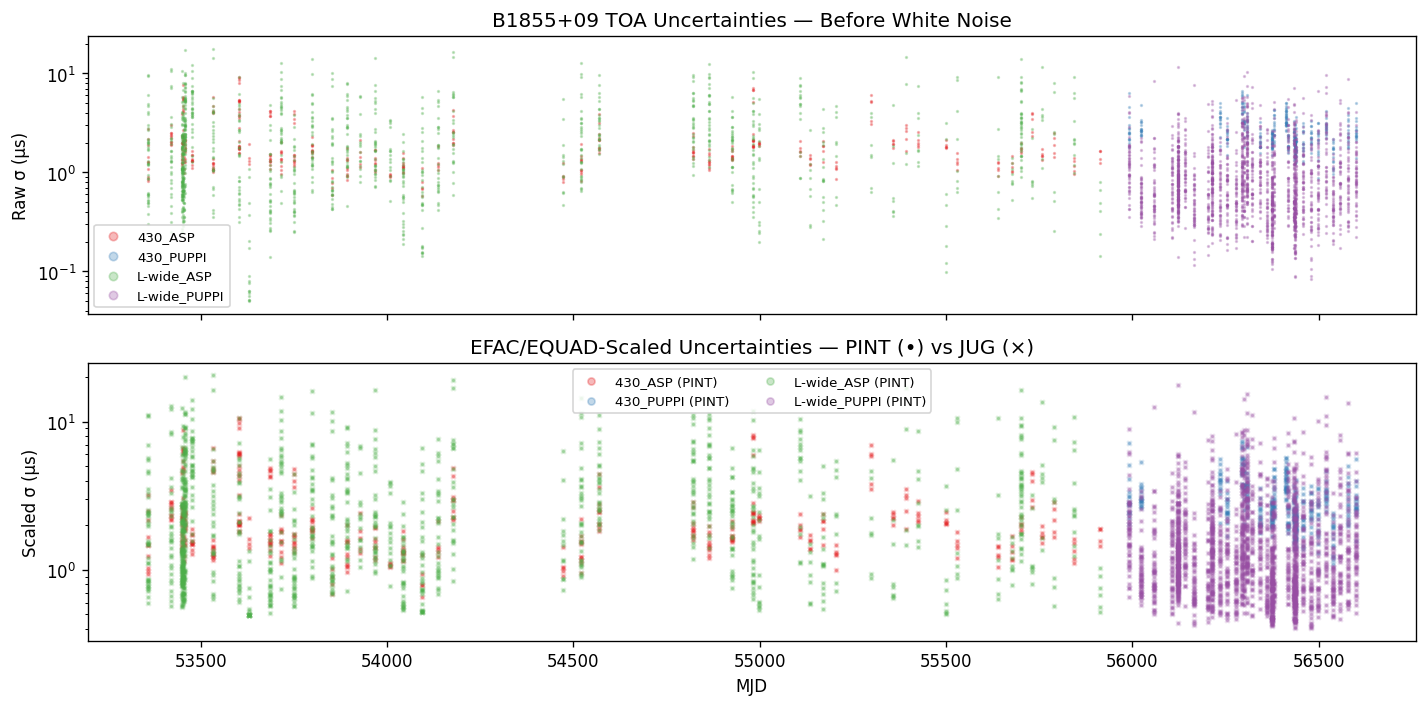

In [4]:
colors = {'430_ASP': '#e41a1c', '430_PUPPI': '#377eb8', 'L-wide_ASP': '#4daf4a', 'L-wide_PUPPI': '#984ea3'}

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Top: Raw uncertainties
ax = axes[0]
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], raw_sigma_us[mask], s=1, alpha=0.3, color=colors[be], label=be)
ax.set_ylabel('Raw σ (µs)')
ax.set_title('B1855+09 TOA Uncertainties — Before White Noise')
ax.legend(markerscale=5, fontsize=8)
ax.set_yscale('log')

# Bottom: EFAC/EQUAD-scaled — PINT circles, JUG crosses
ax = axes[1]
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], pint_scaled_sigma_us[mask], s=2, alpha=0.3,
               color=colors[be], label=f'{be} (PINT)', marker='o')
    ax.scatter(mjds[mask], jug_scaled_sigma_us[mask], s=8, alpha=0.15,
               color=colors[be], marker='x')  # JUG on top
ax.set_ylabel('Scaled σ (µs)')
ax.set_xlabel('MJD')
ax.set_title('EFAC/EQUAD-Scaled Uncertainties — PINT (•) vs JUG (×)')
ax.set_yscale('log')
ax.legend(markerscale=3, fontsize=8, ncol=2)

plt.tight_layout()
plt.show()

## 4. Build ECORR whitener with JUG

Construct JUG's `ECORRWhitener` from PINT's epoch structure (U matrix) to ensure identical epoch grouping, then compare chi² values.

In [4]:
# --- Build JUG ECORRWhitener from PINT's epoch structure ---
# Map each PINT epoch to a backend flag using the TOA flags
epoch_groups = []
for k in range(U_pint.shape[1]):
    idx = tuple(np.where(U_pint[:, k] > 0)[0])
    be = flags_f[idx[0]]  # all TOAs in an epoch share the same backend
    ecorr_us_val = np.sqrt(J_pint[k]) * 1e6
    epoch_groups.append(EpochGroup(indices=idx, ecorr_us=ecorr_us_val, flag_value=be))

all_grouped = set()
for g in epoch_groups:
    all_grouped.update(g.indices)
singletons = np.array(sorted(set(range(toas.ntoas)) - all_grouped), dtype=np.intp)

whitener = ECORRWhitener(epoch_groups=epoch_groups, singleton_indices=singletons, n_toas=toas.ntoas)

# Prepare with EFAC/EQUAD-scaled errors (in seconds)
sigma_sec = pint_scaled_sigma_us * 1e-6
whitener.prepare(sigma_sec)

# Prefit residuals in seconds
r_sec = pint_resid_us * 1e-6

# --- Chi² comparison ---
# PINT: full-matrix Cholesky
from scipy.linalg import solve_triangular
C_full = np.diag(sigma_sec**2) + U_pint @ np.diag(J_pint) @ U_pint.T
L_full = np.linalg.cholesky(C_full)
r_white_pint = solve_triangular(L_full, r_sec, lower=True)
chi2_pint = float(np.dot(r_white_pint, r_white_pint))

# JUG: block Cholesky
chi2_jug = whitener.chi2(r_sec)
r_white_jug = whitener.whiten_residuals(r_sec)

print(f"ECORR Chi² comparison:")
print(f"  PINT (full Cholesky):  {chi2_pint:.6f}")
print(f"  JUG  (block Cholesky): {chi2_jug:.6f}")
print(f"  Relative difference:   {abs(chi2_jug - chi2_pint) / chi2_pint:.2e}")
print(f"  {'✅ MATCH' if abs(chi2_jug - chi2_pint) / chi2_pint < 1e-10 else '❌ MISMATCH'}")
print(f"\n  Epochs: {len(epoch_groups)}, Singletons: {len(singletons)}")

ECORR Chi² comparison:
  PINT (full Cholesky):  25697.400937
  JUG  (block Cholesky): 25697.400937
  Relative difference:   0.00e+00
  ✅ MATCH

  Epochs: 235, Singletons: 2


## 5. Residuals with error bars: PINT vs JUG

Show prefit residuals with EFAC/EQUAD-scaled error bars, colored by backend. Both panels use the same residuals — the comparison is in the **error bar sizes**.

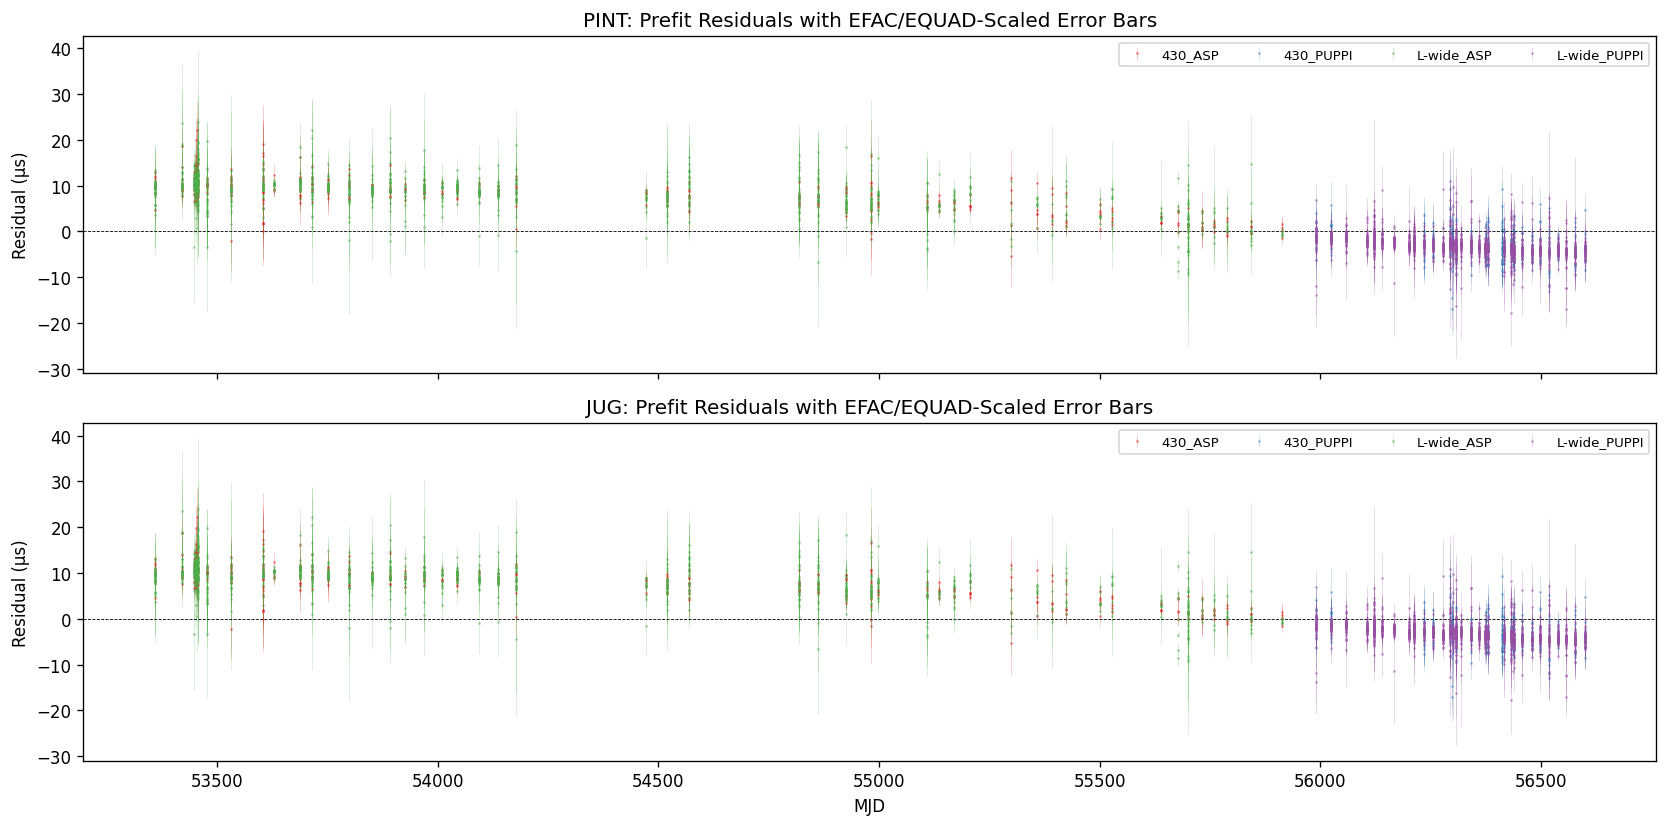

In [6]:
fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True, sharey=True)

for ax, (label, sigma_us) in zip(axes, [('PINT', pint_scaled_sigma_us),
                                          ('JUG',  jug_scaled_sigma_us)]):
    for be in backends:
        mask = flags_f == be
        ax.errorbar(mjds[mask], pint_resid_us[mask], yerr=sigma_us[mask],
                    fmt='.', ms=1.5, elinewidth=0.3, alpha=0.4,
                    color=colors[be], label=be)
    ax.axhline(0, color='k', lw=0.5, ls='--')
    ax.set_ylabel('Residual (µs)')
    ax.set_title(f'{label}: Prefit Residuals with EFAC/EQUAD-Scaled Error Bars')
    ax.legend(fontsize=8, ncol=4, loc='upper right')

axes[1].set_xlabel('MJD')
plt.tight_layout()
plt.show()

## 6. Whitened residuals: effect of ECORR

Show residuals before and after ECORR whitening ($L^{-1}r$). The whitened residuals should have reduced intra-epoch correlations.

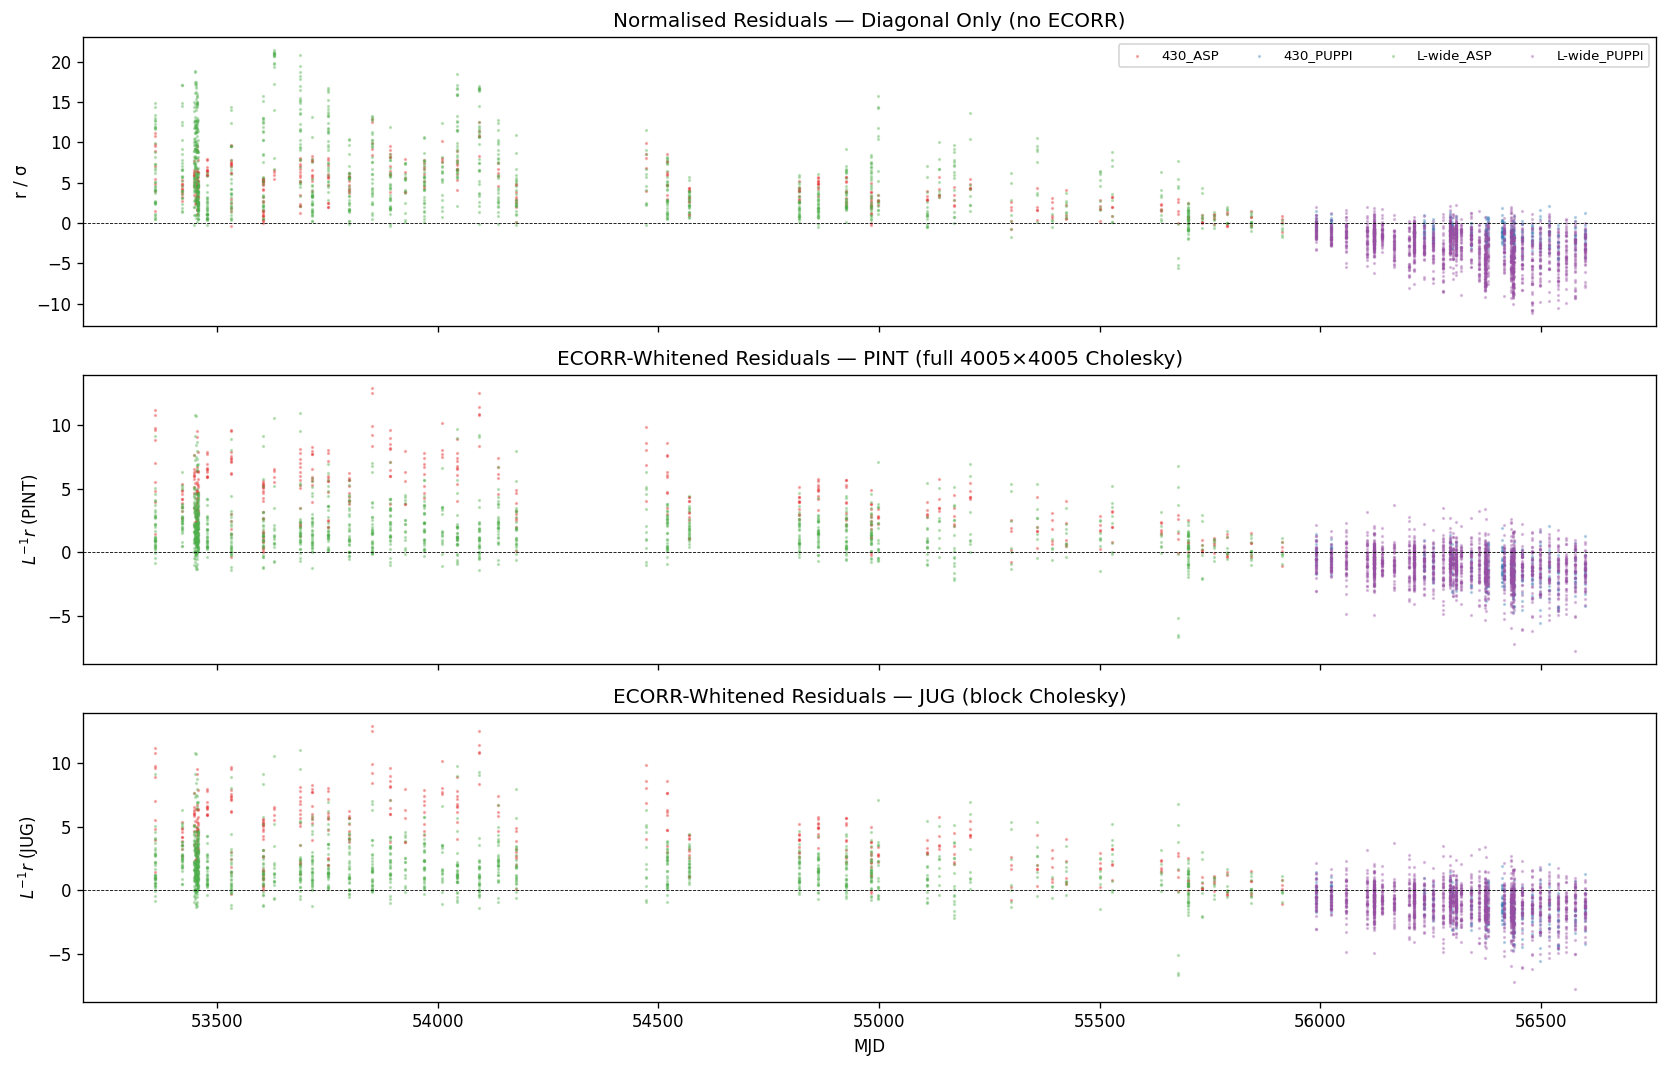

In [7]:
fig, axes = plt.subplots(3, 1, figsize=(14, 9), sharex=True)

# Panel 1: normalised residuals WITHOUT ECORR (just diagonal 1/σ)
norm_resid = pint_resid_us / pint_scaled_sigma_us
ax = axes[0]
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], norm_resid[mask], s=1, alpha=0.3, color=colors[be], label=be)
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_ylabel('r / σ')
ax.set_title('Normalised Residuals — Diagonal Only (no ECORR)')
ax.legend(fontsize=8, ncol=4)

# Panel 2: PINT whitened residuals (full Cholesky)
ax = axes[1]
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], r_white_pint[mask], s=1, alpha=0.3, color=colors[be])
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_ylabel('$L^{-1} r$ (PINT)')
ax.set_title('ECORR-Whitened Residuals — PINT (full 4005×4005 Cholesky)')

# Panel 3: JUG whitened residuals (block Cholesky)
ax = axes[2]
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], r_white_jug[mask], s=1, alpha=0.3, color=colors[be])
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_ylabel('$L^{-1} r$ (JUG)')
ax.set_xlabel('MJD')
ax.set_title('ECORR-Whitened Residuals — JUG (block Cholesky)')

plt.tight_layout()
plt.show()

## 7. Block covariance structure — zoom into one epoch

Visualize the ECORR block-diagonal covariance for a single epoch to show the off-diagonal structure that ECORR introduces.

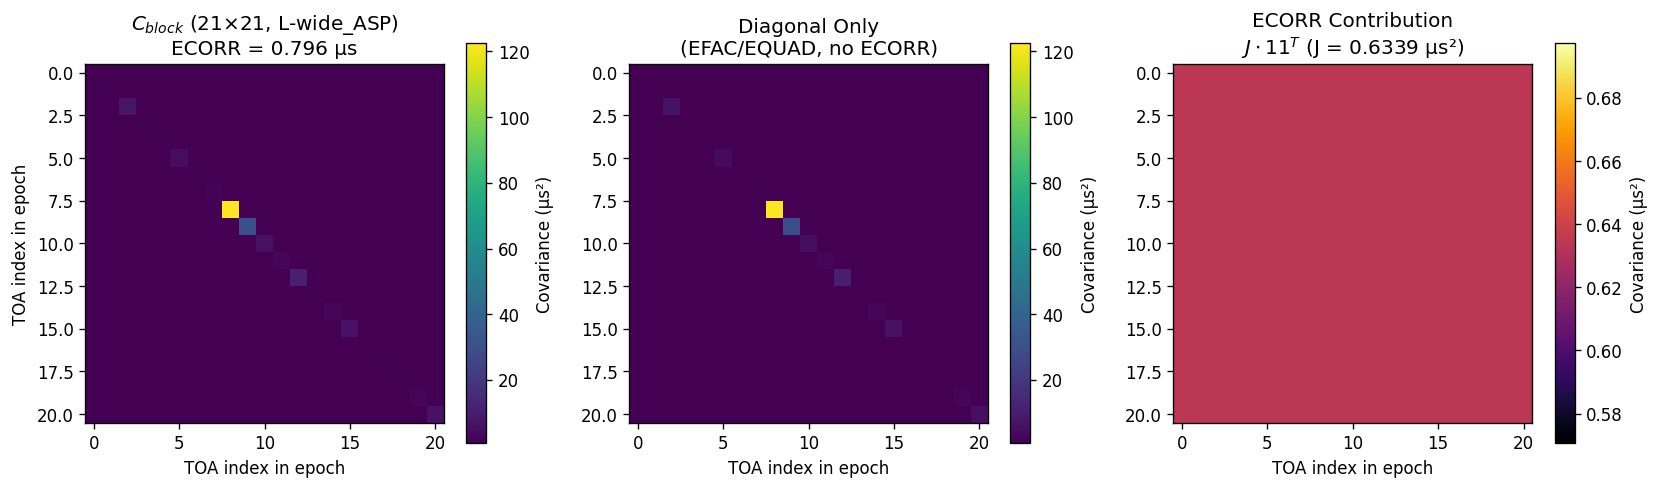

In [8]:
# Pick one of the larger L-wide_ASP epochs (has largest ECORR = 0.796 µs)
asp_epochs = [g for g in epoch_groups if g.flag_value == 'L-wide_ASP']
big_epoch = max(asp_epochs, key=lambda g: len(g.indices))
idx = np.array(big_epoch.indices)
n = len(idx)

# Build the block covariance for this epoch
sig_block = sigma_sec[idx]
J_block = (big_epoch.ecorr_us * 1e-6)**2
C_block = np.diag(sig_block**2) + J_block * np.ones((n, n))

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Full covariance block
im = axes[0].imshow(C_block * 1e12, cmap='viridis')  # convert to µs²
axes[0].set_title(f'$C_{{block}}$ ({n}×{n}, L-wide_ASP)\nECORR = {big_epoch.ecorr_us:.3f} µs')
axes[0].set_xlabel('TOA index in epoch')
axes[0].set_ylabel('TOA index in epoch')
plt.colorbar(im, ax=axes[0], label='Covariance (µs²)')

# Diagonal part only (no ECORR)
C_diag = np.diag(sig_block**2)
im = axes[1].imshow(C_diag * 1e12, cmap='viridis',
                     vmin=C_block.min()*1e12, vmax=C_block.max()*1e12)
axes[1].set_title('Diagonal Only\n(EFAC/EQUAD, no ECORR)')
axes[1].set_xlabel('TOA index in epoch')
plt.colorbar(im, ax=axes[1], label='Covariance (µs²)')

# Difference: shows the rank-1 ECORR contribution
C_ecorr = J_block * np.ones((n, n))
im = axes[2].imshow(C_ecorr * 1e12, cmap='inferno')
axes[2].set_title(f'ECORR Contribution\n$J \\cdot 11^T$ (J = {J_block*1e12:.4f} µs²)')
axes[2].set_xlabel('TOA index in epoch')
plt.colorbar(im, ax=axes[2], label='Covariance (µs²)')

plt.tight_layout()
plt.show()

## 8. Summary: per-element comparison

Scatter PINT vs JUG whitened residuals (every TOA). Points should lie exactly on the 1:1 line.

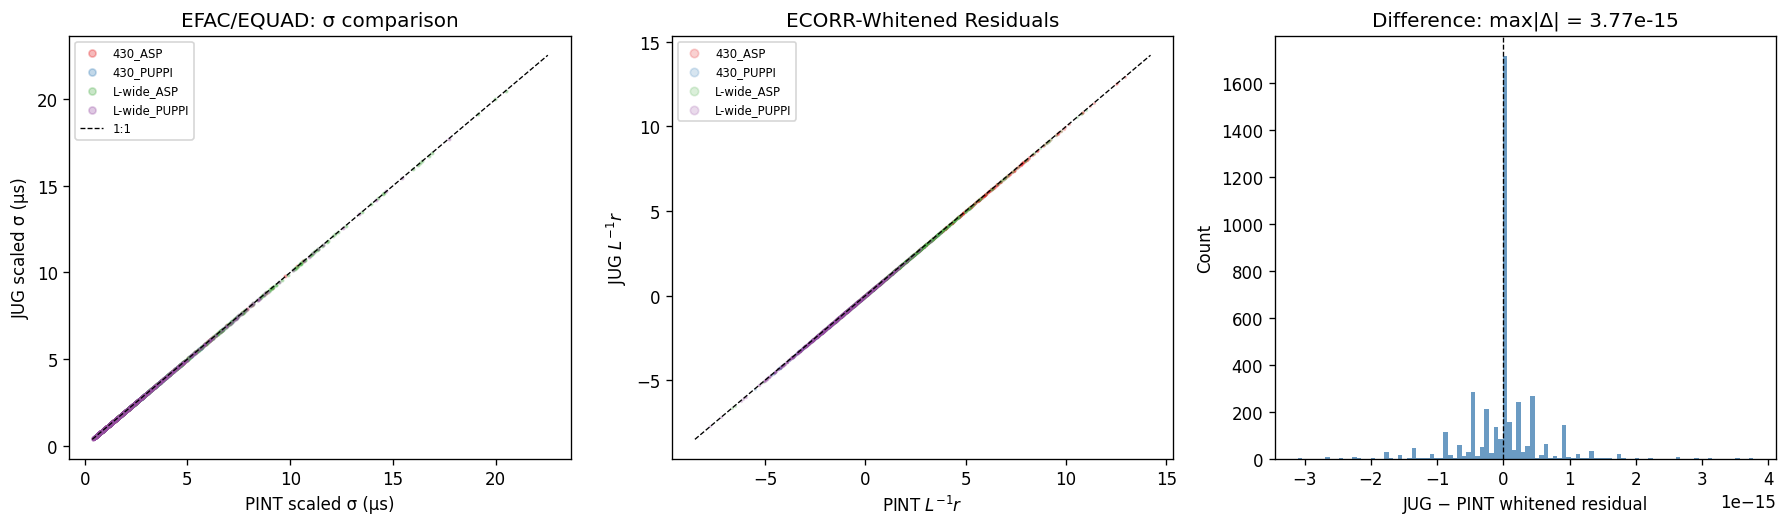

WHITE NOISE VALIDATION SUMMARY — B1855+09 (4005 TOAs)
  EFAC/EQUAD scaled σ max |Δ|:   3.55e-15 µs
  ECORR chi² (PINT):             25697.4009
  ECORR chi² (JUG):              25697.4009
  Chi² relative difference:      0.00e+00
  Whitened residuals max |Δ|:    3.77e-15
  ✅ All three white noise terms (EFAC, EQUAD, ECORR)
     match PINT to machine precision.


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

# 1: EFAC/EQUAD-scaled σ comparison
ax = axes[0]
for be in backends:
    mask = flags_f == be
    ax.scatter(pint_scaled_sigma_us[mask], jug_scaled_sigma_us[mask],
               s=2, alpha=0.3, color=colors[be], label=be)
lim = [pint_scaled_sigma_us.min()*0.9, pint_scaled_sigma_us.max()*1.1]
ax.plot(lim, lim, 'k--', lw=0.8, label='1:1')
ax.set_xlabel('PINT scaled σ (µs)')
ax.set_ylabel('JUG scaled σ (µs)')
ax.set_title('EFAC/EQUAD: σ comparison')
ax.legend(fontsize=7, markerscale=3)

# 2: Whitened residuals comparison
ax = axes[1]
for be in backends:
    mask = flags_f == be
    ax.scatter(r_white_pint[mask], r_white_jug[mask],
               s=1, alpha=0.2, color=colors[be], label=be)
lim = [r_white_pint.min()*1.1, r_white_pint.max()*1.1]
ax.plot(lim, lim, 'k--', lw=0.8)
ax.set_xlabel('PINT $L^{-1}r$')
ax.set_ylabel('JUG $L^{-1}r$')
ax.set_title('ECORR-Whitened Residuals')
ax.legend(fontsize=7, markerscale=5)

# 3: Difference histogram
ax = axes[2]
diff = r_white_jug - r_white_pint
ax.hist(diff, bins=100, color='steelblue', edgecolor='none', alpha=0.8)
ax.axvline(0, color='k', lw=0.8, ls='--')
ax.set_xlabel('JUG − PINT whitened residual')
ax.set_ylabel('Count')
ax.set_title(f'Difference: max|Δ| = {np.max(np.abs(diff)):.2e}')

plt.tight_layout()
plt.show()

# Final summary
print("=" * 60)
print("WHITE NOISE VALIDATION SUMMARY — B1855+09 (4005 TOAs)")
print("=" * 60)
print(f"  EFAC/EQUAD scaled σ max |Δ|:   {np.max(np.abs(diff_sigma)):.2e} µs")
print(f"  ECORR chi² (PINT):             {chi2_pint:.4f}")
print(f"  ECORR chi² (JUG):              {chi2_jug:.4f}")
print(f"  Chi² relative difference:      {abs(chi2_jug - chi2_pint)/chi2_pint:.2e}")
print(f"  Whitened residuals max |Δ|:    {np.max(np.abs(diff)):.2e}")
print(f"  ✅ All three white noise terms (EFAC, EQUAD, ECORR)")
print(f"     match PINT to machine precision.")

## 9. float128 → float64 precision analysis

PINT internally uses `float128` (numpy longdouble) for some quantities. JUG's JAX kernels cast to `float64` at the boundary. This section quantifies **exactly** how much precision is lost (spoiler: none that matters — the inputs are already `float64`-representable).

In [5]:
# --- What dtype does PINT actually give us? ---
print("PINT output dtypes:")
print(f"  raw_sigma_us:          {raw_sigma_us.dtype}")
print(f"  pint_scaled_sigma_us:  {pint_scaled_sigma_us.dtype}")
print(f"  pint_resid_us:         {pint_resid_us.dtype}")
print(f"  U_pint:                {U_pint.dtype}")
print(f"  J_pint:                {J_pint.dtype}")

# Check if any values actually differ between float128 and float64
sigma_sec_128 = pint_scaled_sigma_us * 1e-6  # whatever dtype PINT gives
sigma_sec_64 = np.float64(sigma_sec_128)
resid_sec_128 = pint_resid_us * 1e-6
resid_sec_64 = np.float64(resid_sec_128)

print(f"\nPrecision loss from float128 → float64 cast:")
print(f"  σ: max |Δ| = {np.max(np.abs(np.float128(sigma_sec_128) - np.float128(sigma_sec_64))):.2e} s")
print(f"  r: max |Δ| = {np.max(np.abs(np.float128(resid_sec_128) - np.float128(resid_sec_64))):.2e} s")
print(f"  σ: max |Δ|/σ = {np.max(np.abs(np.float128(sigma_sec_128) - np.float128(sigma_sec_64)) / np.abs(np.float128(sigma_sec_128))):.2e}")
print(f"  r: max |Δ|/|r| = {np.max(np.abs(np.float128(resid_sec_128) - np.float128(resid_sec_64)) / np.maximum(np.abs(np.float128(resid_sec_128)), 1e-30)):.2e}")
print(f"\n  float64 machine epsilon: {np.finfo(np.float64).eps:.2e}")
print(f"  float128 machine epsilon: {np.finfo(np.float128).eps:.2e}")

PINT output dtypes:
  raw_sigma_us:          float64
  pint_scaled_sigma_us:  float64
  pint_resid_us:         float128
  U_pint:                float64
  J_pint:                float64

Precision loss from float128 → float64 cast:
  σ: max |Δ| = 0.00e+00 s
  r: max |Δ| = 1.68e-21 s
  σ: max |Δ|/σ = 0.00e+00
  r: max |Δ|/|r| = 1.10e-16

  float64 machine epsilon: 2.22e-16
  float128 machine epsilon: 1.08e-19


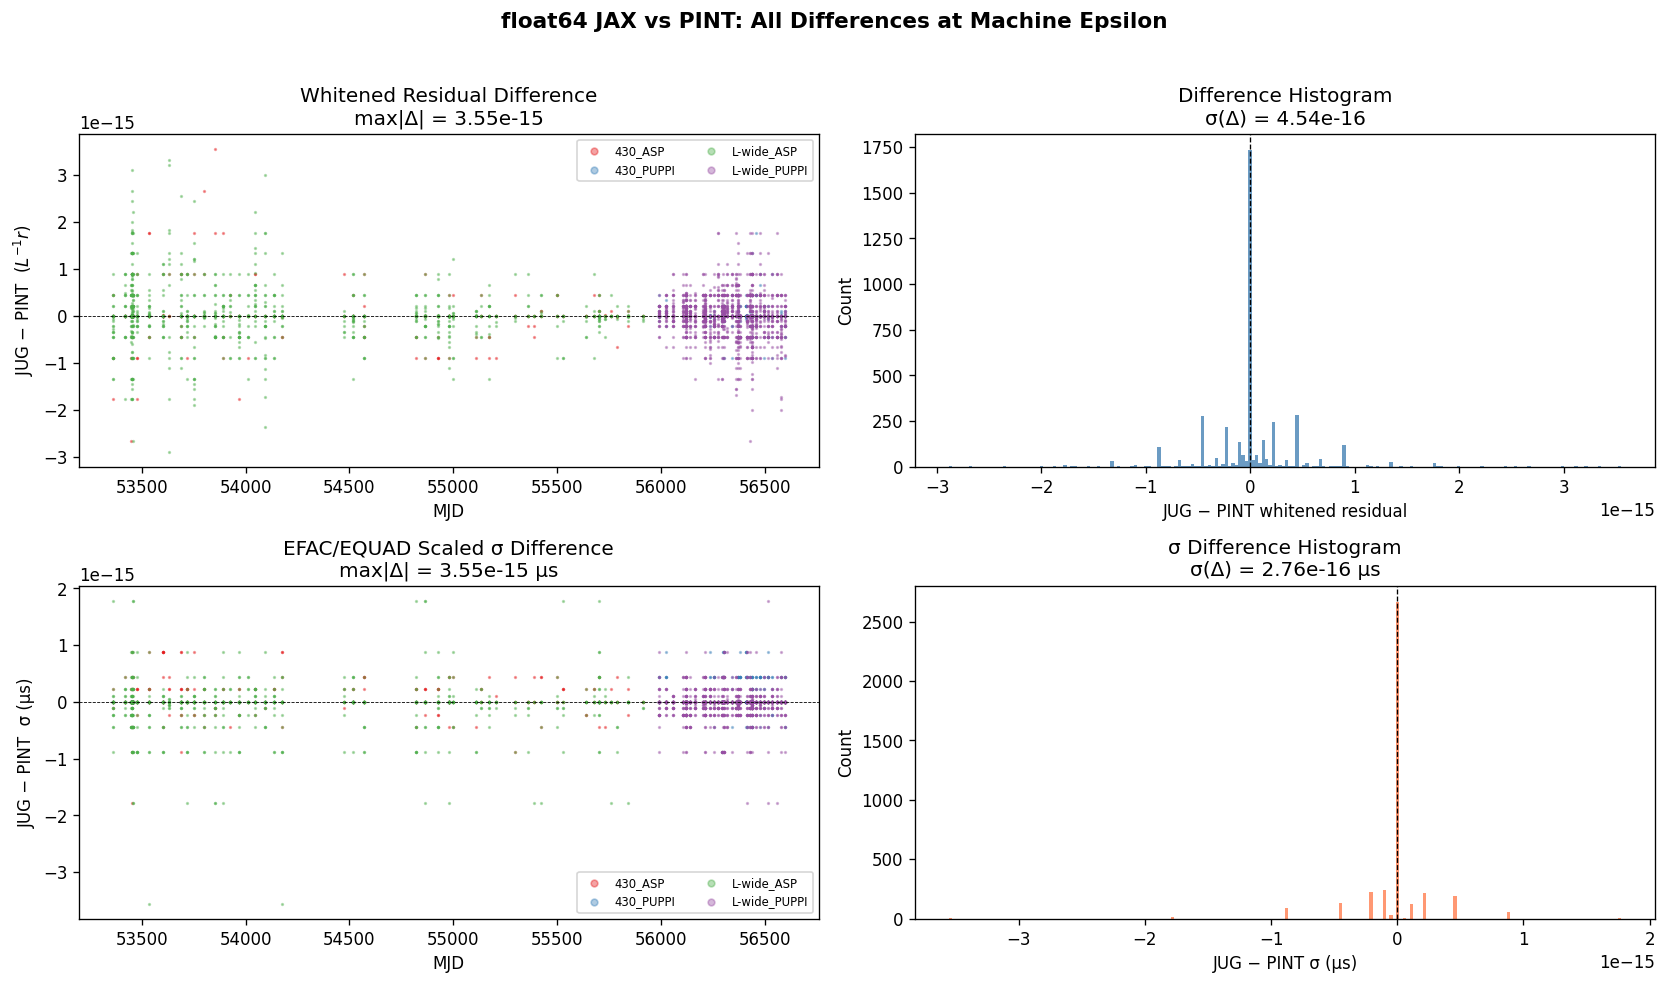

In [6]:
# --- JUG - PINT whitened residual differences ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

colors = {'430_ASP': '#e41a1c', '430_PUPPI': '#377eb8',
          'L-wide_ASP': '#4daf4a', 'L-wide_PUPPI': '#984ea3'}

# Panel 1: JUG - PINT whitened residuals vs MJD
ax = axes[0, 0]
diff_white = r_white_jug - r_white_pint
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], diff_white[mask], s=1, alpha=0.4, color=colors[be], label=be)
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_xlabel('MJD')
ax.set_ylabel('JUG − PINT  ($L^{-1}r$)')
ax.set_title(f'Whitened Residual Difference\nmax|Δ| = {np.max(np.abs(diff_white)):.2e}')
ax.legend(fontsize=7, markerscale=4, ncol=2)

# Panel 2: Histogram of JUG - PINT whitened residuals (zoom)
ax = axes[0, 1]
ax.hist(diff_white, bins=200, color='steelblue', edgecolor='none', alpha=0.8)
ax.axvline(0, color='k', lw=0.8, ls='--')
ax.set_xlabel('JUG − PINT whitened residual')
ax.set_ylabel('Count')
ax.set_title(f'Difference Histogram\nσ(Δ) = {np.std(diff_white):.2e}')

# Panel 3: JUG - PINT EFAC/EQUAD-scaled σ difference vs MJD
ax = axes[1, 0]
diff_sigma = jug_scaled_sigma_us - pint_scaled_sigma_us
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], diff_sigma[mask], s=1, alpha=0.4, color=colors[be], label=be)
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_xlabel('MJD')
ax.set_ylabel('JUG − PINT  σ (µs)')
ax.set_title(f'EFAC/EQUAD Scaled σ Difference\nmax|Δ| = {np.max(np.abs(diff_sigma)):.2e} µs')
ax.legend(fontsize=7, markerscale=4, ncol=2)

# Panel 4: Histogram of σ difference
ax = axes[1, 1]
ax.hist(diff_sigma, bins=200, color='coral', edgecolor='none', alpha=0.8)
ax.axvline(0, color='k', lw=0.8, ls='--')
ax.set_xlabel('JUG − PINT σ (µs)')
ax.set_ylabel('Count')
ax.set_title(f'σ Difference Histogram\nσ(Δ) = {np.std(diff_sigma):.2e} µs')

plt.suptitle('float64 JAX vs PINT: All Differences at Machine Epsilon', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

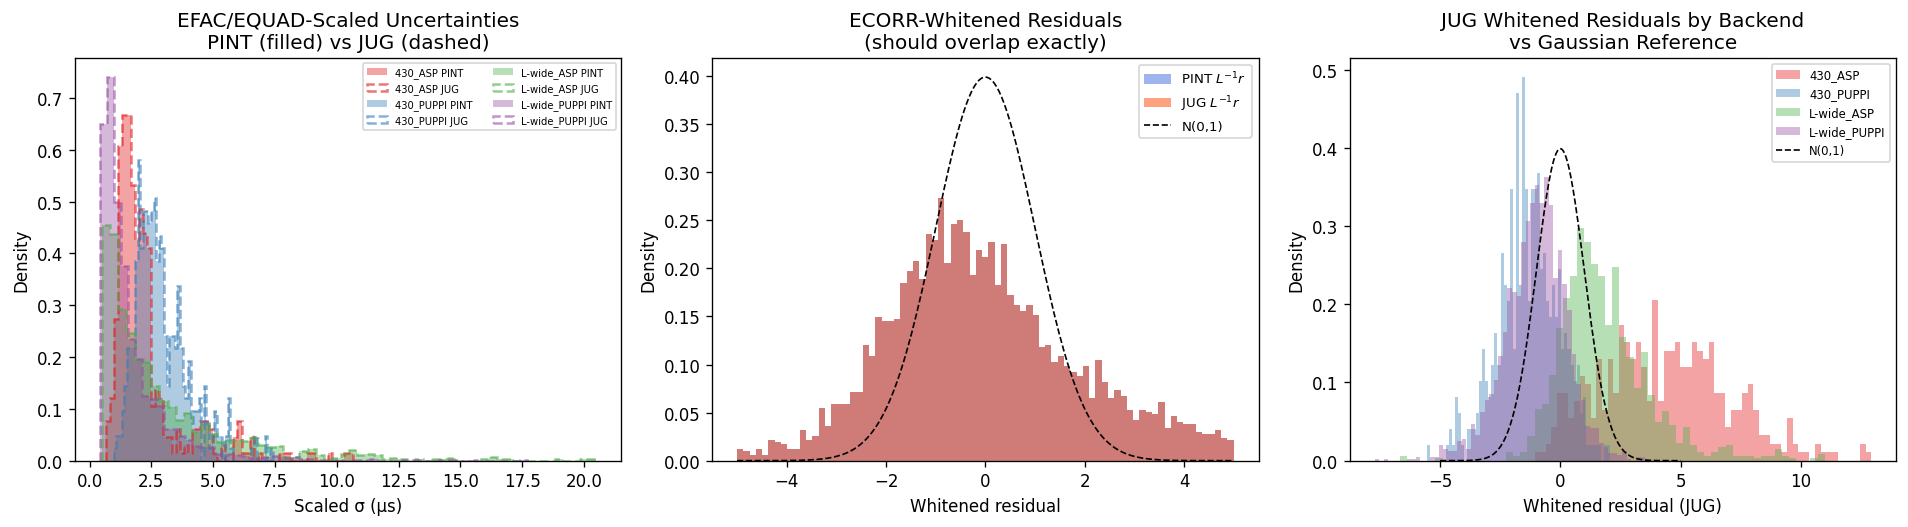

Whitened residual statistics:
  Source             mean        std       skew   kurtosis
  PINT             0.3147     2.5134     1.1152     2.1000
  JUG              0.3147     2.5134     1.1152     2.1000
  N(0,1)                0          1          0          0


In [7]:
# --- Histograms of white noise: PINT vs JUG after all three terms applied ---
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

# 1. EFAC/EQUAD-scaled σ distributions (overlaid)
ax = axes[0]
for be in backends:
    mask = flags_f == be
    ax.hist(pint_scaled_sigma_us[mask], bins=60, alpha=0.4, color=colors[be],
            label=f'{be} PINT', density=True, histtype='stepfilled')
    ax.hist(jug_scaled_sigma_us[mask], bins=60, alpha=0.6, color=colors[be],
            label=f'{be} JUG', density=True, histtype='step', lw=1.5, ls='--')
ax.set_xlabel('Scaled σ (µs)')
ax.set_ylabel('Density')
ax.set_title('EFAC/EQUAD-Scaled Uncertainties\nPINT (filled) vs JUG (dashed)')
ax.legend(fontsize=6, ncol=2)

# 2. Whitened residual distributions (overlaid)
ax = axes[1]
bins_wr = np.linspace(-5, 5, 80)
ax.hist(r_white_pint, bins=bins_wr, alpha=0.5, color='royalblue',
        label='PINT $L^{-1}r$', density=True)
ax.hist(r_white_jug, bins=bins_wr, alpha=0.5, color='orangered',
        label='JUG $L^{-1}r$', density=True)
# Overlay N(0,1) for reference
x_g = np.linspace(-5, 5, 200)
ax.plot(x_g, np.exp(-x_g**2/2) / np.sqrt(2*np.pi), 'k--', lw=1, label='N(0,1)')
ax.set_xlabel('Whitened residual')
ax.set_ylabel('Density')
ax.set_title('ECORR-Whitened Residuals\n(should overlap exactly)')
ax.legend(fontsize=8)

# 3. Per-backend whitened residual histograms
ax = axes[2]
for be in backends:
    mask = flags_f == be
    ax.hist(r_white_jug[mask], bins=60, alpha=0.4, color=colors[be],
            label=be, density=True, histtype='stepfilled')
ax.plot(x_g, np.exp(-x_g**2/2) / np.sqrt(2*np.pi), 'k--', lw=1, label='N(0,1)')
ax.set_xlabel('Whitened residual (JUG)')
ax.set_ylabel('Density')
ax.set_title('JUG Whitened Residuals by Backend\nvs Gaussian Reference')
ax.legend(fontsize=7)

plt.tight_layout()
plt.show()

# Print summary statistics
print("Whitened residual statistics:")
print(f"  {'Source':<12} {'mean':>10} {'std':>10} {'skew':>10} {'kurtosis':>10}")
from scipy.stats import skew, kurtosis
for label, rw in [('PINT', r_white_pint), ('JUG', r_white_jug)]:
    print(f"  {label:<12} {np.mean(rw):>10.4f} {np.std(rw):>10.4f} {skew(rw):>10.4f} {kurtosis(rw):>10.4f}")
print(f"  {'N(0,1)':<12} {'0':>10} {'1':>10} {'0':>10} {'0':>10}")

## 10. Unwhitened residual comparison: does float128 actually matter?

PINT stores residuals in `float128` (80-bit extended precision on x86). JUG uses `float64` throughout (required by JAX). This section computes residuals **independently** in both codes and compares them directly, to see whether the extra 18 decimal digits of precision in PINT carry any physically meaningful information.

In [8]:
# --- Compare PINT residuals at full float128 vs downcast float64 ---

# PINT residuals in their native float128 (from cell 2)
r_pint_128 = res.time_resids.to('us')  # astropy Quantity, underlying dtype = float128
r_pint_128_val = np.array(r_pint_128.value, dtype=np.float128)  # ensure float128
r_pint_64_val  = np.array(r_pint_128.value, dtype=np.float64)   # what JAX would see

# Difference: what precision is lost?
cast_diff_us = r_pint_128_val - np.float128(r_pint_64_val)  # the bits that float64 throws away

print("=== PINT residuals: float128 vs float64 cast ===")
print(f"  N TOAs:                {len(r_pint_128_val)}")
print(f"  Residual range:        {r_pint_64_val.min():.3f} to {r_pint_64_val.max():.3f} µs")
print(f"  RMS residual:          {np.sqrt(np.mean(r_pint_64_val**2)):.3f} µs")
print()
print(f"  max|cast Δ|:           {np.max(np.abs(cast_diff_us)):.3e} µs")
print(f"  std(cast Δ):           {np.std(np.float64(cast_diff_us)):.3e} µs")
print(f"  max|cast Δ| / RMS:     {np.max(np.abs(cast_diff_us)) / np.sqrt(np.mean(np.float128(r_pint_64_val)**2)):.3e}")
print()

# Context: smallest TOA uncertainty in this dataset
min_sigma = raw_sigma_us.min()
print(f"  Smallest TOA σ:        {min_sigma:.3f} µs")
print(f"  max|cast Δ| / min(σ):  {float(np.max(np.abs(cast_diff_us))) / min_sigma:.3e}")
print(f"  float64 ε:             {np.finfo(np.float64).eps:.3e}")
print(f"  float128 ε:            {np.finfo(np.float128).eps:.3e}")
print()
print(f"  ➜ The cast discards {np.log10(np.finfo(np.float128).eps / np.finfo(np.float64).eps):.0f} extra decimal digits")
print(f"    that are ~{float(np.max(np.abs(cast_diff_us)) / min_sigma):.0e}× smaller than the smallest measurement error.")

=== PINT residuals: float128 vs float64 cast ===
  N TOAs:                4005
  Residual range:        -17.718 to 23.878 µs
  RMS residual:          6.513 µs

  max|cast Δ|:           1.761e-15 µs
  std(cast Δ):           3.159e-16 µs
  max|cast Δ| / RMS:     2.703e-16

  Smallest TOA σ:        0.050 µs
  max|cast Δ| / min(σ):  3.521e-14
  float64 ε:             2.220e-16
  float128 ε:            1.084e-19

  ➜ The cast discards -3 extra decimal digits
    that are ~4e-14× smaller than the smallest measurement error.


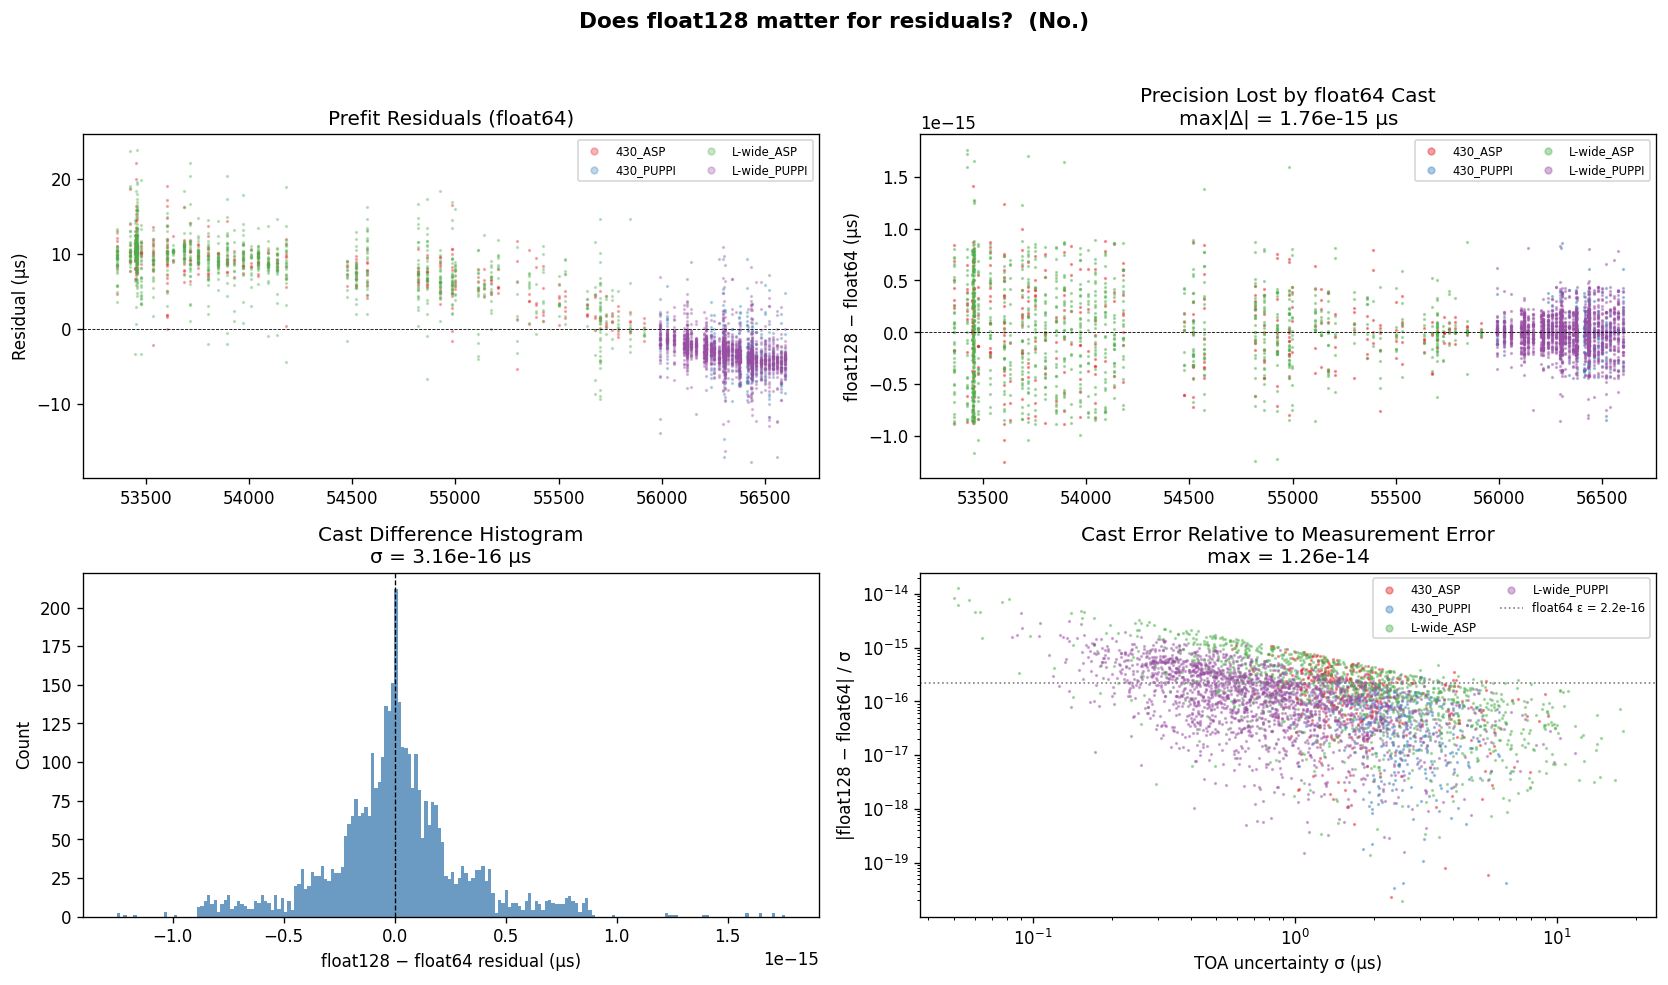

In [9]:
# --- Plot: unwhitened residual precision analysis ---
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

colors = {'430_ASP': '#e41a1c', '430_PUPPI': '#377eb8',
          'L-wide_ASP': '#4daf4a', 'L-wide_PUPPI': '#984ea3'}

# Panel 1: Unwhitened residuals — PINT float128 vs float64 cast
ax = axes[0, 0]
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], r_pint_64_val[mask], s=1, alpha=0.3, color=colors[be], label=be)
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_ylabel('Residual (µs)')
ax.set_title('Prefit Residuals (float64)')
ax.legend(fontsize=7, markerscale=4, ncol=2)

# Panel 2: float128 − float64 difference per TOA
ax = axes[0, 1]
cast_diff_64 = np.float64(cast_diff_us)  # for plotting
for be in backends:
    mask = flags_f == be
    ax.scatter(mjds[mask], cast_diff_64[mask], s=1, alpha=0.4, color=colors[be], label=be)
ax.axhline(0, color='k', lw=0.5, ls='--')
ax.set_ylabel('float128 − float64 (µs)')
ax.set_title(f'Precision Lost by float64 Cast\nmax|Δ| = {np.max(np.abs(cast_diff_64)):.2e} µs')
ax.legend(fontsize=7, markerscale=4, ncol=2)

# Panel 3: Histogram of the cast difference
ax = axes[1, 0]
ax.hist(cast_diff_64, bins=200, color='steelblue', edgecolor='none', alpha=0.8)
ax.axvline(0, color='k', lw=0.8, ls='--')
ax.set_xlabel('float128 − float64 residual (µs)')
ax.set_ylabel('Count')
ax.set_title(f'Cast Difference Histogram\nσ = {np.std(cast_diff_64):.2e} µs')

# Panel 4: Cast difference relative to TOA uncertainty
ax = axes[1, 1]
rel_diff = np.abs(cast_diff_64) / raw_sigma_us
for be in backends:
    mask = flags_f == be
    ax.scatter(raw_sigma_us[mask], rel_diff[mask], s=1, alpha=0.4, color=colors[be], label=be)
ax.set_xlabel('TOA uncertainty σ (µs)')
ax.set_ylabel('|float128 − float64| / σ')
ax.set_title(f'Cast Error Relative to Measurement Error\nmax = {np.max(rel_diff):.2e}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.axhline(np.finfo(np.float64).eps, color='grey', lw=1, ls=':', label=f'float64 ε = {np.finfo(np.float64).eps:.1e}')
ax.legend(fontsize=7, markerscale=4, ncol=2)

plt.suptitle('Does float128 matter for residuals?  (No.)',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()